# **Proyecto Final Ciencia de Datos en Python**

In [79]:
#%% Librerías
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
#%% Clase pFinal
class pFinal():
    def __init__(self, dName):
        #Por defecto el valor de currentTraining es SP
        #lastModel y autoModel permiten almacenar los modelos para las distintas equis
        self.lastModel = {}
        self.autoModel = {}
        #currentTraining permite generalizar la seleccion de variables para entrenar
        self.currentTraining = 'SP'
        self.dName = dName
        self.coefs = {}
        #Se carga la data al crear la instancia de la clase pFinal
        fPath = os.getcwd()
        dPath = 'proyecto_data'
        data = np.load(os.path.join(fPath, dPath, self.dName))
        #Dividir la data en dos.
        lim = int(0.8*len(data))
        self.data=pd.DataFrame(data[:lim], columns=['SP','OQ','1Fsf','TotRMS','Year','LF'])
        self.testData = pd.DataFrame(data[lim:], columns=['SP','OQ','1Fsf','TotRMS','Year','LF'])
    def getStats(self):
        average = dict(self.data.mean(axis = 0))
        maxCol = self.data.max(axis = 0)
        minCol = self.data.min(axis = 0)
        peak = dict(maxCol-minCol)
        maxCol = dict(maxCol)
        minCol = dict(minCol)
        desvEst = dict(self.data.std(axis = 0))
        self.stats = pd.DataFrame(index = ['average','maxCol','minCol','peak','desvEst'],
                     data = (average,maxCol,minCol,peak,desvEst))
    def graphHist(self):
        for i in self.data.columns:
            hist = sns.displot(self.data[i],kind='hist')
    def r2(self):   
        yav = self.stats['SP']['average']
        ty = self.data['SP'].apply(lambda y: y - yav)
        sumvarY = self.data['SP'].apply(lambda y: (y-yav)**2).sum()
        for i in self.data.columns[1:]:
            xav = self.stats[i]['average']
            num = (self.data[i].apply(lambda x: x - xav)*ty).sum()
            sumvarX = self.data[i].apply(lambda x: (x-xav)**2).sum()
            deno = np.sqrt(sumvarY*sumvarX)
            self.coefs[i] = num/deno
    def plots(self):
        x=0
        for i in self.data.columns[1:]:
            plt.scatter(self.data[i], self.data['SP'], s=0.5, c='r', alpha=0.5)
            #Para tener una mejor referencia se agrega el nombre de la variable al titulo
            plt.title("{} - r2: {}".format(i,self.coefs[i]))
            plt.xlim(self.stats[i]['minCol']-1, self.stats[i]['maxCol']+1)
            plt.show()
    def entrenar(self,x,y,epoch=0,impErr=0,alpha=0):
        #Se obtiene el nombre de la columna ingresada
        #Permite el control de los limites en los ejes de las graficas y
        #los puntos de referencia en la grafica de modelos por iteracion.
        self.currentTraining = x.name
        #Se inicializan los parametros del modelo.
        #betas = np.random.rand(2)
        #b0 es betas[0] y b1 es betass[1]
        betas = [1,1]
        #Iteraciones del entrenamiento.
        errors = []
        models = {}
        for i in range(1,epoch+1):
            #Almacenar modelo
            models[i] = betas
            #Prediccion de y
            x = np.array(x)
            M = np.transpose(np.array([x, np.full_like(x,1)]))
            y = np.array(y)
            yPredict = np.dot(M, betas)
            #Calcular error.
            n = len(y)
            e = (1/(2*n)) * np.sum((y-yPredict)**2)
            errors.append(e)
            if i % impErr == 0:
                #
                #print(self.currentTraining)
                print('Iteracion {}:\n {}'.format(i, e))
            #Grads[0] es el gradiente del error respecto de b1 y Grads[1] de b0
            grads = 1/len(x) * np.dot((yPredict-y),M)
            #Actualización de los parámetros.
            betas = betas - alpha*grads[::-1]
        self.lastModel[self.currentTraining] = betas
        return models, errors
    def graphError(self,errors=[]):
        a = np.linspace(1,len(errors),len(errors),dtype = int)
        plt.scatter(a, errors, s=0.5, c='r', alpha=0.5)
        plt.title('Error vs Iteración - {}'.format(self.currentTraining))
        plt.xlim(0, len(errors)+1)
        plt.show()
    def graphModels(self,models = {}, n=1, compare = False):
        for i in range(1,len(models)+1):
            if i%n == 0:
                x = self.data[self.currentTraining]
                M = np.transpose(np.array([x, np.full_like(x,1)]))
                yPredict = np.dot(M, models[i])
                plt.scatter(x,yPredict, s =1, c ='g', alpha = 0.5, label= 'Modelo')
                if compare:
                    plt.scatter(x, self.data['SP'], s =1, c = 'b', alpha = 0.5, label = "Original")
                plt.title('Variable {} - Iteración #{}'.format(self.currentTraining,i))
                plt.xlim(self.stats[self.currentTraining]['minCol']-1, self.stats[self.currentTraining]['maxCol']+1)
                plt.legend()
                plt.show()    
    def autoTraining(self,x,y):
        regresion = LinearRegression(positive = True, normalize = True)
        xTrain = np.reshape(np.array([x]),(len(x),1))
        yTrain = np.reshape(np.array([y]),(len(y),1))
        regresion.fit(xTrain, yTrain)
        self.autoModel[x.name] = regresion
    def graphAutoModel(self,variable=""):
        auto = self.autoModel[variable]
        xTrain = np.reshape(np.array(self.data[variable]),(len(self.data[variable]),1))
        yPredict = auto.predict(xTrain)
        plt.scatter(self.data[variable], yPredict, s =1, c = 'y', alpha = 0.5, label = 'Auto')
        plt.scatter(self.data[variable], self.data['SP'], s =1, c= 'b', alpha = 0.5, label = 'Original')
        plt.title('Grafica de modelo scikitlearn para {}'.format(variable))
        plt.legend()
        plt.show()
    def predictCalculator(self,variable = "", manual = [], auto = [], vec = [], flag = True):
        res = {}
        if flag:
            try:
                manual = self.lastModel[variable]
                auto = self.autoModel[variable]
            except:
                print('Pendiente de cargar modelo(s).\n')
        #Se prepara la matriz
        M = np.transpose(np.array([self.data[variable], np.full_like(self.data[variable],1)]))
        xTemp = np.reshape(np.array(self.data[variable]),(len(self.data[variable]),1))
        manualPredict = np.dot(M, manual)
        autoPredict = np.array(auto.predict(xTemp))
        averagePredict = (manualPredict + autoPredict)/2
        if len(vec) != 0:
            V = np.transpose(np.array([vec, np.full_like(vec,1)]))
            vTemp = np.reshape(np.array(vec),(len(vec),1))
            mPredict = np.dot(V, manual)
            aPredict = np.reshape(np.array(auto.predict(vTemp)),(len(vec),))
            avPredict = (mPredict + aPredict)/2
            res['vector_Manual'] = mPredict
            res['vector_Auto'] = aPredict
            res['vector_Average'] = avPredict
        res['averagePredict'] = averagePredict
        return res
    def modelsTester(self, variable = "", compare = False):
        res = self.predictCalculator(variable, vec = self.testData[variable], flag = True)
        y = self.testData['SP']
        #El absoluto no afecta porque se eleva al cuadrado
        #Los tres vectores siguientes son el error. El valor absoluto de (y - y predict)
        errManual = abs(y-res['vector_Manual'])
        errAuto = abs(y-res['vector_Auto'])
        errAverage = abs(y-res['vector_Average'])
        n = len(y)
        eManual = (1/(2*n)) * np.sum(errManual**2)
        eAuto = (1/(2*n)) * np.sum(errAuto**2)
        eAverage = (1/(2*n)) * np.sum(errAverage**2)
        #Graficas de errores.
        plt.scatter(self.testData[variable], errManual, s =1, c = 'b', alpha = 0.5)
        plt.title('Manual - error: {}'.format(eManual))
        plt.show()
        plt.scatter(self.testData[variable], errAuto, s =1, c = 'b', alpha = 0.5)
        plt.title('Auto - error: {}'.format(eAuto))
        plt.show()
        plt.scatter(self.testData[variable], errAverage, s =1, c = 'b', alpha = 0.5)
        plt.title('Average - error: {}'.format(eAverage))
        plt.show()
        if compare:
            plt.scatter(self.testData[variable],res['vector_Manual'], s =1, c = 'r', alpha = 0.5, label= 'Manual')
            plt.scatter(self.testData[variable],res['vector_Auto'], s =1, c = 'y', alpha = 0.5, label = 'Auto')
            plt.scatter(self.testData[variable],res['vector_Average'], s =1, c = 'g', alpha = 0.5, label = 'Average')
            plt.scatter(self.testData[variable] ,y , s =0.5, c = 'b', alpha = 1, label = 'Original')
            plt.legend()
            plt.title("Todos los modelos vs y")
        
#Instanciar y obtener estadisticas
pFinal = pFinal('proyecto_training_data.npy')
stats = pFinal.getStats()

# **Análisis inicial de variables**

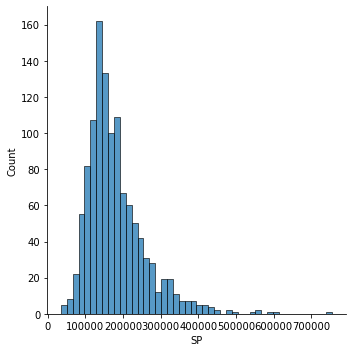

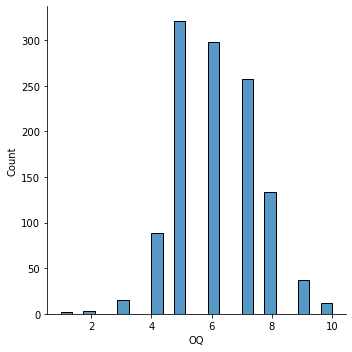

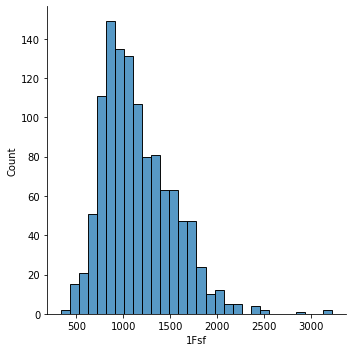

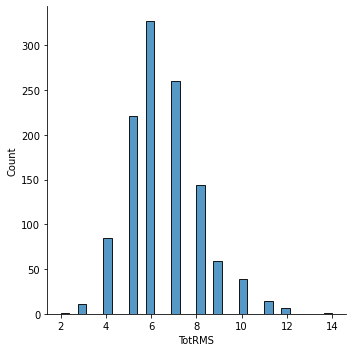

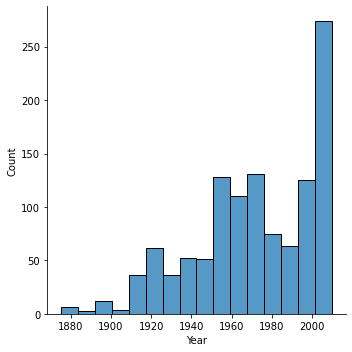

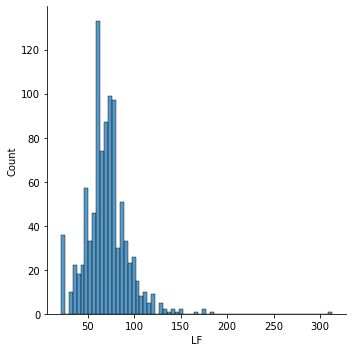

In [80]:
#Grafica de histograma
pFinal.graphHist()

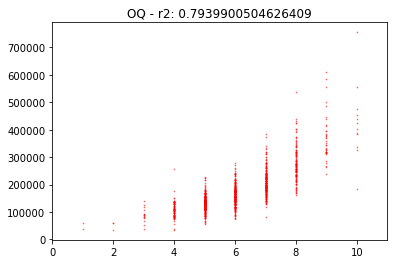

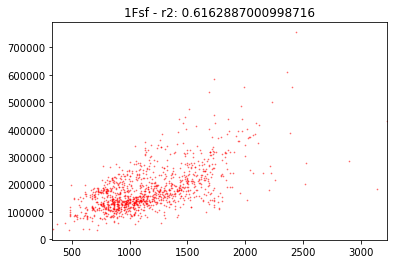

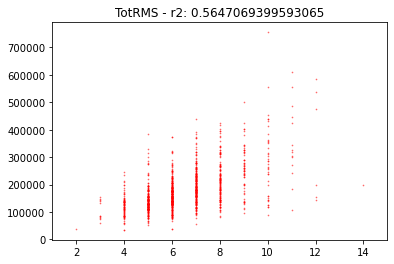

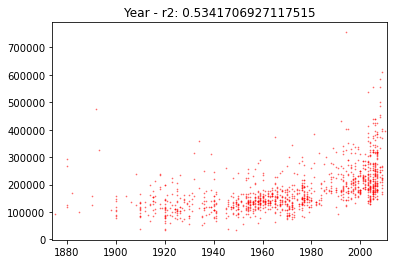

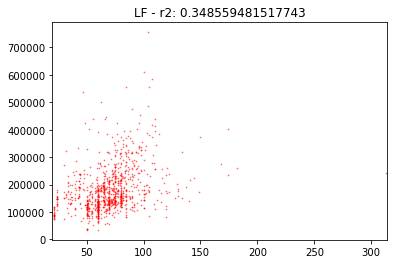

In [81]:
#Calcular coeficientes y grafica de variables independientes vs dependiente
pFinal.r2()
pFinal.plots()

# **Selección de variables para entrenar.**

# Variable 1 - 1Fsf - First Floor Surface

In [82]:
#Entrenar
models, errors = pFinal.entrenar(pFinal.data['1Fsf'], pFinal.data['SP'],200,100,0.000009)

Iteracion 100:
 2377593248.494044
Iteracion 200:
 2166598142.8810215


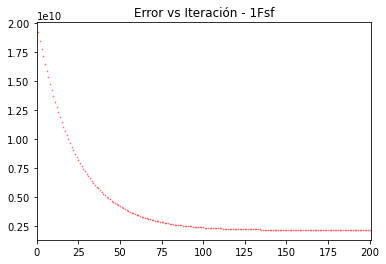

In [83]:
##### Graficar error
pFinal.graphError(errors)

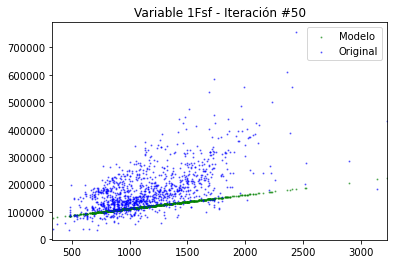

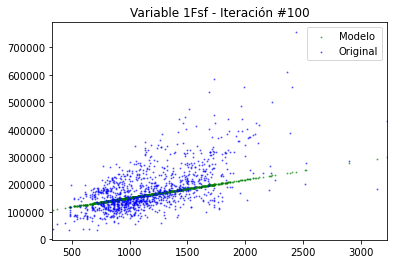

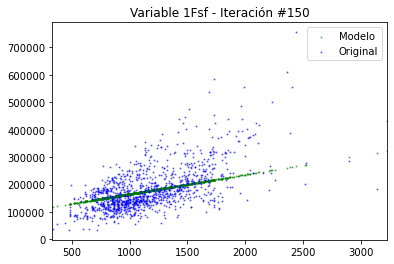

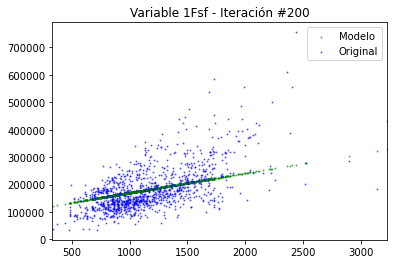

In [84]:
#Graficar modelos
pFinal.graphModels(models, 50, True)

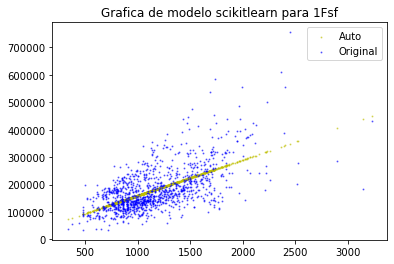

In [85]:
#Entranamiento con scikitlearn
pFinal.autoTraining(pFinal.data['1Fsf'], pFinal.data['SP'])
pFinal.graphAutoModel('1Fsf')

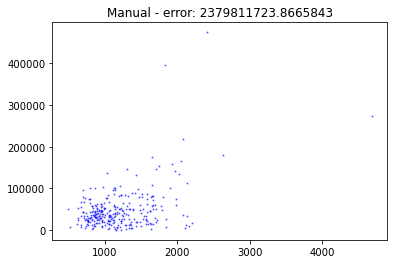

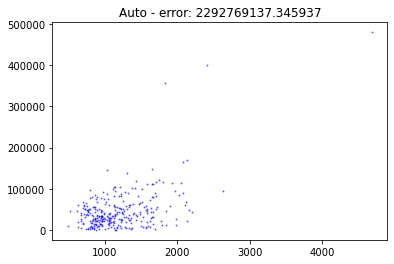

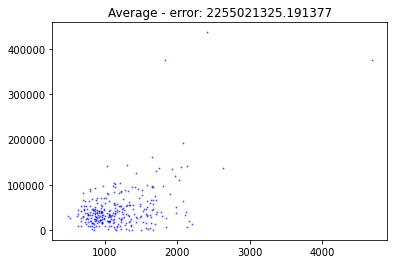

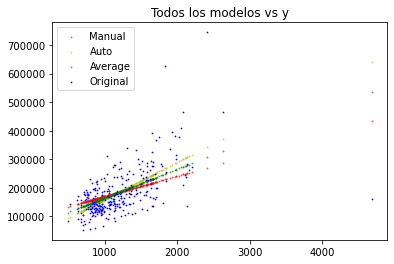

In [86]:
#Prueba modelos
pFinal.modelsTester('1Fsf', True)

#### Para el caso anterior (variable 1Fsf), el modelo que tiene el menor error es Average, el promedio de los otros dos modelos. Por lo tanto, el modelo promediado es la mejor opción.

# Variable 2 - Year - Year

In [87]:
#Entrenar
n2=15
models, errors = pFinal.entrenar(pFinal.data['Year'], pFinal.data['SP'],n2,n2/2,0.000099)

Iteracion 15:
 3046415823.960876


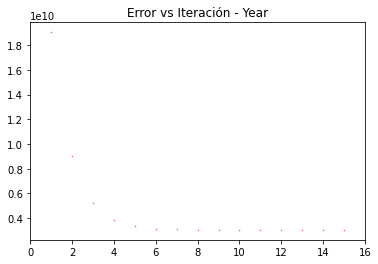

In [76]:
#Graficar error
pFinal.graphError(errors)

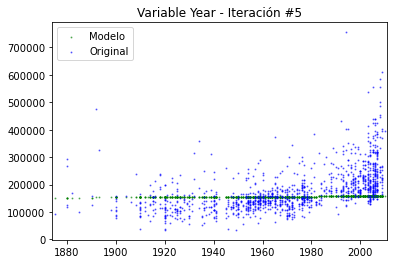

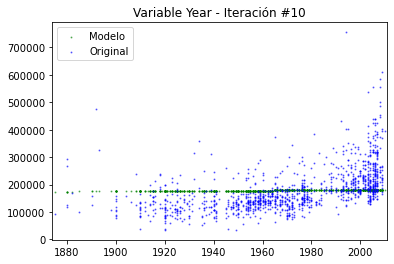

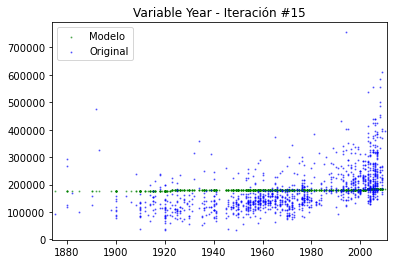

In [77]:

pFinal.graphModels(models, 5, True)

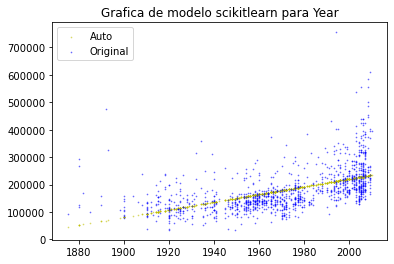

In [78]:
#Entranamiento con scikitlearn de Year
pFinal.autoTraining(pFinal.data['Year'], pFinal.data['SP'])
pFinal.graphAutoModel('Year')

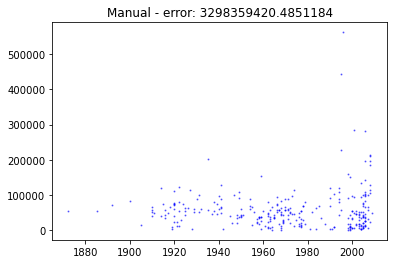

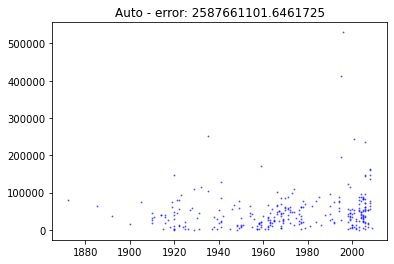

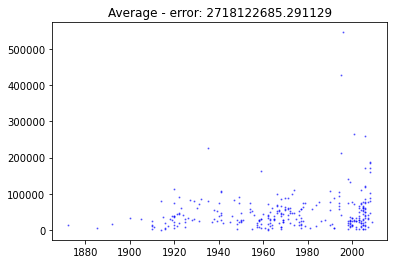

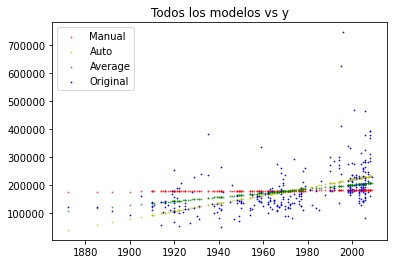

In [63]:
#Prueba modelos
pFinal.modelsTester('Year', True)